In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('emotion_sentimen_dataset.csv', index_col=0)
df.sample(10)

,text,Emotion
779111,i want to share with you what it feels like bu...,neutral
40687,i learnt the meaning of christmas itself a few...,happiness
67155,i mean feeling insulted and hurt is a reaction...,neutral
766120,i like dramatic eyes so i usually grab black e...,love
589473,i reached the check out lane i was feeling hig...,neutral
4665,i believe in you moment we all feel til then i...,neutral
427471,im feeling decidedly irritated with matt today,neutral
456366,i feel so beaten up and played around with,neutral
713438,i do not really feel boring watching this,neutral
454072,im feeling very skeptical,neutral


In [ ]:
df.shape

(839555, 2)

In [ ]:
# Analyzing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 839555 entries, 0 to 839554
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     839555 non-null  object
 1   Emotion  839555 non-null  object
dtypes: object(2)
memory usage: 19.2+ MB


In [ ]:
# Checking for missing values
df.isnull().sum()

text       0
Emotion    0
dtype: int64

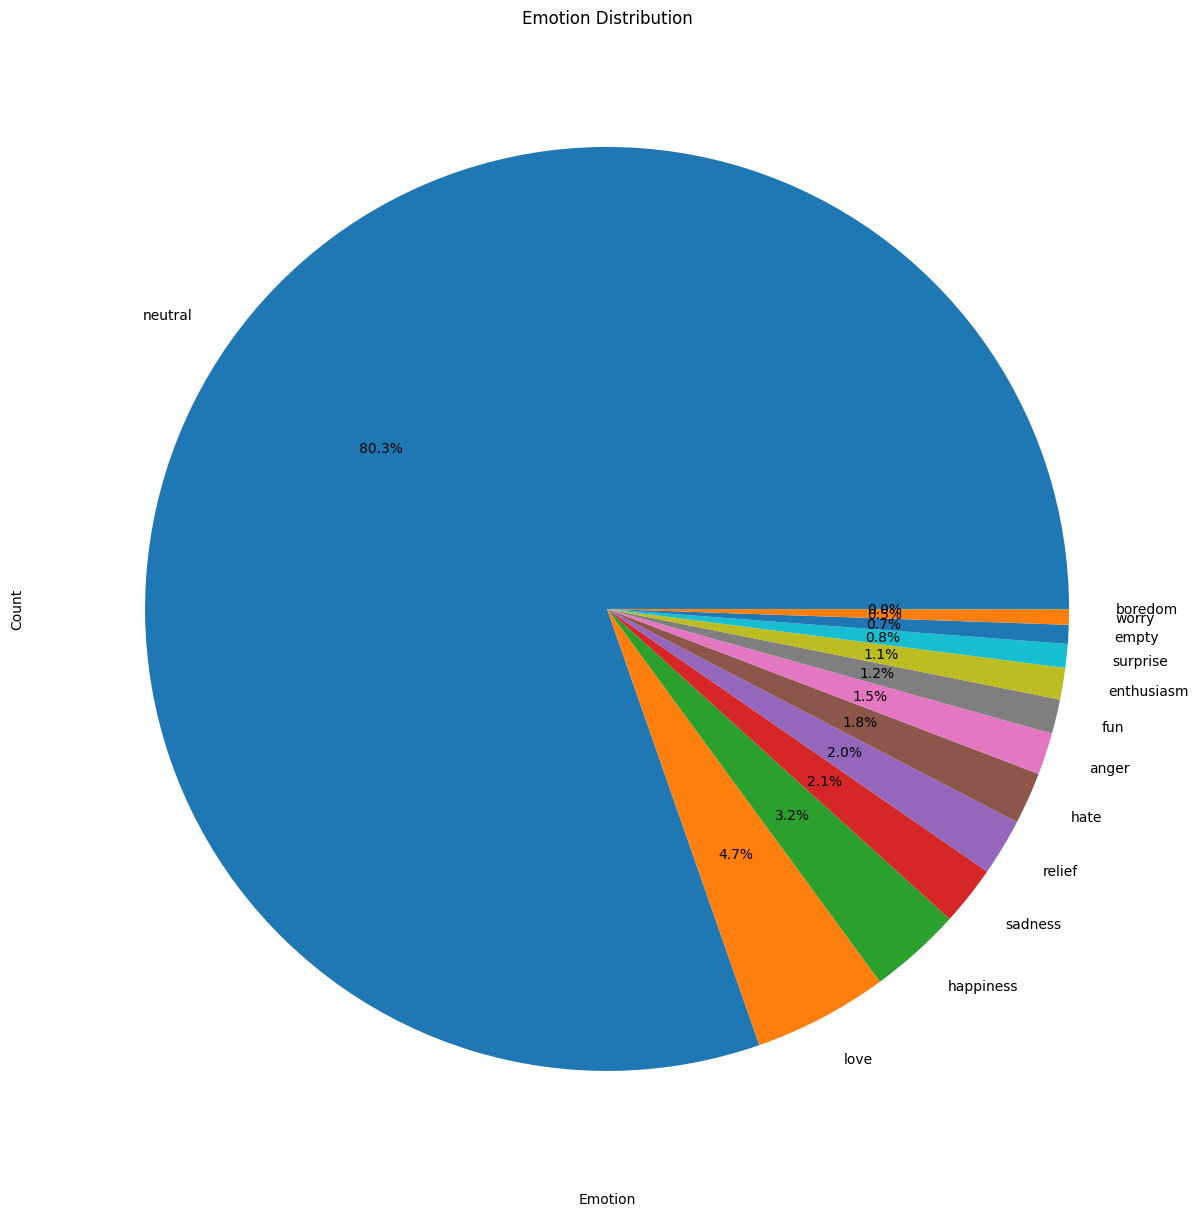

In [ ]:
# Visualizing the data
df['Emotion'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(15, 15))
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution')
plt.show()

In [ ]:
# Split the data into training and testing sets
train = df.text
labels = df.Emotion

In [ ]:
# Label encoding the labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_encoded.shape

unique_labels = list(set(labels))
label_encoded_mapping = {label: encoded_label for label, encoded_label in zip(unique_labels, encoder.transform(unique_labels))}
label_encoded_mapping

{'anger': 0,
 'hate': 6,
 'empty': 2,
 'sadness': 10,
 'neutral': 8,
 'worry': 12,
 'relief': 9,
 'happiness': 5,
 'surprise': 11,
 'boredom': 1,
 'enthusiasm': 3,
 'fun': 4,
 'love': 7}

In [ ]:
num_classes = labels.nunique()
num_classes

13

In [ ]:
# Tokenizing the text
tokenizer = Tokenizer(num_words=100000, oov_token='unknown')
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index
print(len(word_index))

# Padding the sequences
train_sequences = tokenizer.texts_to_sequences(train)
train_padded = pad_sequences(train_sequences, padding='post', truncating='post')

75302


In [ ]:
# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(train_padded, labels_encoded, test_size=0.2, random_state=45)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((671644, 178), (671644,), (167911, 178), (167911,))

In [ ]:
# Building the model
model = Sequential()
model.add(layers.Embedding(100000, 16, input_length=x_train.shape[1]))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 178, 16)           1600000   
                                                                 
 lstm_4 (LSTM)               (None, 178, 64)           20736     
                                                                 
 flatten (Flatten)           (None, 11392)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                729152    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 13)               

In [ ]:
# Training the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
20989/20989 [==============================] - 269s 13ms/step - loss: 0.1625 - accuracy: 0.9530 - val_loss: 0.1195 - val_accuracy: 0.9829
Epoch 2/5
20989/20989 [==============================] - 255s 12ms/step - loss: 0.0601 - accuracy: 0.9850 - val_loss: 0.0466 - val_accuracy: 0.9898
Epoch 3/5
20989/20989 [==============================] - 257s 12ms/step - loss: 0.0263 - accuracy: 0.9938 - val_loss: 0.0418 - val_accuracy: 0.9848
Epoch 4/5
20989/20989 [==============================] - 237s 11ms/step - loss: 0.0154 - accuracy: 0.9964 - val_loss: 0.0207 - val_accuracy: 0.9950
Epoch 5/5
20989/20989 [==============================] - 233s 11ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.0139 - val_accuracy: 0.9974


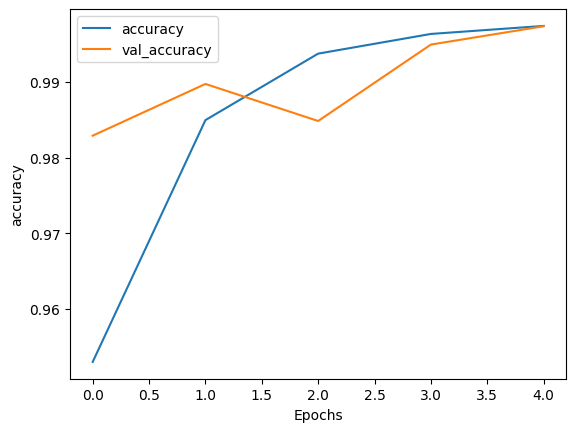

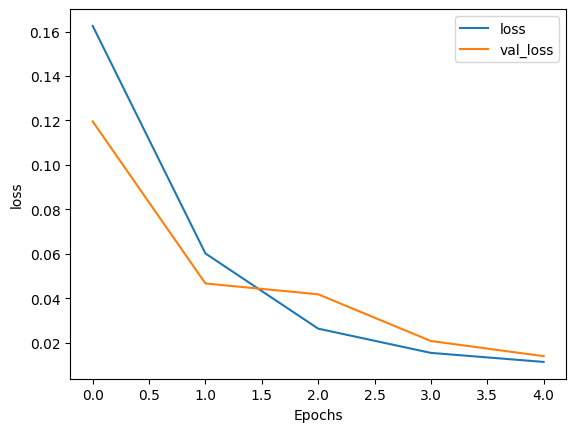

In [ ]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Predicting

In [ ]:
maxlen = x_train.shape[1]

love = "Walking hand in hand under the starlit sky, they felt an overwhelming love for each other."
hate = "The mere sight of him filled her with hate, a burning anger that consumed her."
surprise = "As she opened the door, a chorus of 'Happy Birthday!' greeted her, taking her completely by surprise."

def predict_emotion(sentence, model):
  sequences = tokenizer.texts_to_sequences([sentence])
  padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
  probabilities = model.predict(padded, verbose=0)
  predicted_class_index = np.argmax(probabilities)

  predicted_class_probability = probabilities[0][predicted_class_index]
  formatted_probability = "{:.2f}".format(predicted_class_probability*100)
  predicted_emotion = encoder.classes_[predicted_class_index]
  result = f'Emotion: {predicted_emotion}, Probability: {formatted_probability}'
  return result


print(predict_emotion(love, model))
print(predict_emotion(hate, model))
print(predict_emotion(surprise, model))

Emotion: love, Probability: 100.00
Emotion: hate, Probability: 99.76
Emotion: surprise, Probability: 100.00


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
model.save('/content/model/emotion_nlp.keras')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model('/content/model')
neutral = "The unfair treatment and constant disrespect from my colleagues infuriated me beyond measure"
print(predict_emotion(neutral, loaded_model))

The unfair treatment and constant disrespect from my colleagues infuriated me beyond measure
Emotion: neutral, Probability: 100.00


In [ ]:
import joblib
encoder_path = "encoder.pkl"
joblib.dump(encoder, encoder_path)
print("Encoder saved successfully.")

Encoder saved successfully.
